# IBM Employee Attrition Predictor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [2]:
df = pd.read_csv('employee_attrition_preprocessed.csv')
df.head()

,Attrition,Age,BusinessTravel,Research & Development,Sales,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsSinceLastPromotion,YearsWithCurrManager
0,1,41,1,0,1,1,2,2,1,3,...,5993,8,1,11,1,0,0,1,0,5
1,0,49,2,1,0,8,1,3,0,2,...,5130,1,0,23,4,1,3,3,1,7
2,1,37,1,1,0,2,2,4,0,2,...,2090,6,1,15,2,0,3,3,0,0
3,0,33,2,1,0,3,4,4,1,3,...,2909,1,1,11,3,0,3,3,3,0
4,0,27,1,1,0,2,1,1,0,3,...,3468,9,0,12,4,1,3,3,2,2


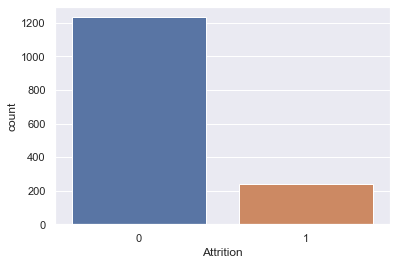

In [3]:
sns.countplot(df.Attrition)

In [4]:
df.Attrition.value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

 The dataset is highly imbalanced. So, we will try different dirrerent methods to deal with it

In [5]:
#Splitting targets and features

y = df.Attrition
X = df.drop('Attrition', axis=1)

In [6]:
# Splitting dataset into training and testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
# Standardizing our dataset

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)    # We standardize test dataset

## Techniques for balancing dataset :

## 1) Upsampling & Downsampling

In [8]:
df_minority = df[df.Attrition == 1]
df_majority = df[df.Attrition ==0]

In [9]:
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression

In [10]:
# Upsampling minority 
df_minority_upsampled = resample(df_minority, replace=True, n_samples=1233, random_state=5)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
print(df_upsampled['Attrition'].value_counts())

# Splitting new dataframe df_upsampled into X & y
X_upsampled = df_upsampled.drop('Attrition', axis=1)
y_upsampled = df_upsampled.Attrition

# Splitting into training and testing dataset
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(X_upsampled, y_upsampled, test_size=0.2, random_state=0)

# Measuring training accuracy
reg_upsampled = LogisticRegression().fit(X_train_upsampled, y_train_upsampled)
print('Training Accuracy: ', reg_upsampled.score(X_train_upsampled, y_train_upsampled))

1    1233
0    1233
Name: Attrition, dtype: int64
Training Accuracy:  0.6850912778904665


In [11]:
# Downsampling minority 
df_majority_downsampled = resample(df_majority, replace=False, n_samples=237, random_state=5)
df_downsampled = pd.concat([df_minority, df_majority_downsampled])
print(df_downsampled['Attrition'].value_counts())

# Splitting new dataframe df_downsampled into X & y
X_downsampled = df_downsampled.drop('Attrition', axis=1)
y_downsampled = df_downsampled.Attrition

# Splitting into training and testing dataset
X_train_downsampled, X_test_downsampled, y_train_downsampled, y_test_downsampled = train_test_split(X_downsampled, y_downsampled, test_size=0.2, random_state=0)

# Measuring training accuracy
reg_downsampled = LogisticRegression().fit(X_train_downsampled, y_train_downsampled)
print('Training Accuracy: ', reg_downsampled.score(X_train_downsampled, y_train_downsampled))

1    237
0    237
Name: Attrition, dtype: int64
Training Accuracy:  0.7044854881266491


## 2) Using Penalised SVM

In [12]:
from sklearn.svm import SVC

model = SVC(kernel='linear', class_weight='balanced').fit(X_train_scaled, y_train)
print('Training Accuracy: ', model.score(X_train_scaled, y_train))

Training Accuracy:  0.7721088435374149


In [13]:
y_pred_svm = model.predict(X_train_scaled)
np.unique(y_pred_svm)

array([0, 1], dtype=int64)

Thus, we can see that even though dataset is not balanced, model is predicting both values 0 & 1.

## 3) Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold 

# We use K Fold Validation
kf = KFold(n_splits=10, random_state=5)

for train_index,test_index in kf.split(X_train_scaled, y_train):
    X_kf_train, X_kf_test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_kf_train, y_kf_test = y_train.iloc[train_index], y_train.iloc[test_index]
    RFC_Model = RandomForestClassifier(n_estimators=500, min_samples_leaf=3).fit(X_kf_train, y_kf_train)
    print('Training Accuracy: ', RFC_Model.score(X_kf_train, y_kf_train))
    print('Validation Accuracy: ', RFC_Model.score(X_kf_test, y_kf_test))
    print('------------------------------------------------')

Training Accuracy:  0.9319470699432892
Validation Accuracy:  0.8813559322033898
------------------------------------------------
Training Accuracy:  0.9357277882797732
Validation Accuracy:  0.8728813559322034
------------------------------------------------
Training Accuracy:  0.9310018903591682
Validation Accuracy:  0.8813559322033898
------------------------------------------------
Training Accuracy:  0.9338374291115312
Validation Accuracy:  0.8559322033898306
------------------------------------------------
Training Accuracy:  0.9310018903591682
Validation Accuracy:  0.8559322033898306
------------------------------------------------
Training Accuracy:  0.9376181474480151
Validation Accuracy:  0.8559322033898306
------------------------------------------------
Training Accuracy:  0.931067044381492
Validation Accuracy:  0.905982905982906
------------------------------------------------
Training Accuracy:  0.9320113314447592
Validation Accuracy:  0.8376068376068376
-------------------

In [15]:
# Our model predicts both values 0 & 1
y_pred_rfc = RFC_Model.predict(X_train_scaled)
np.unique(y_pred_rfc)

array([0, 1], dtype=int64)

# Testing 

In [16]:
print('Upsampled Testing Accuracy: ', reg_upsampled.score(X_test_scaled, y_test))
print('Downsampled Testing Accuracy: ', reg_downsampled.score(X_test_scaled, y_test))
print('SVM Testing Accuracy: ', model.score(X_test_scaled, y_test))
print('Random Forest Testing Accuracy: ', RFC_Model.score(X_test_scaled, y_test))
# Even though accuracy takes a nose-dive in upsampled and downsampled models,
# they are more interpretable.

Upsampled Testing Accuracy:  0.5544217687074829
Downsampled Testing Accuracy:  0.5986394557823129
SVM Testing Accuracy:  0.7721088435374149
Random Forest Testing Accuracy:  0.8503401360544217


In [17]:
# Using Random Forest Regressor
pred = pd.DataFrame()
pred['Actual Values'] = y_test
pred['Predicted Values'] = RFC_Model.predict(X_test_scaled)
pred[pred['Actual Values'] == pred['Predicted Values']].head()

,Actual Values,Predicted Values
442,0,0
1091,0,0
785,0,0
1332,1,1
501,0,0


In [18]:
# Final accuracies of different models
result = pd.DataFrame()
result['Model'] = ['Upsampled Logistic','Downsampled Logistic','SVM','Random Forest Classifier']
result['Accuracy'] = [reg_upsampled.score(X_test_scaled, y_test),
                      reg_downsampled.score(X_test_scaled, y_test),
                      model.score(X_test_scaled, y_test),
                      RFC_Model.score(X_test_scaled, y_test)]
result

,Model,Accuracy
0,Upsampled Logistic,0.554422
1,Downsampled Logistic,0.598639
2,SVM,0.772109
3,Random Forest Classifier,0.850340


## Thus, Random Forest Classifier gives us the best accuracy of 85.03% 